# Decision Trees

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from itertools import product
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load data
X_train_input = np.load("Data/X_train.npy")  # shape (700, 6)
Y_train_input = np.load("Data/Y_train.npy")  # shape (700,)

# Random train/test split (200 for test, 500 for training and cross-validation)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_input, Y_train_input, test_size=200, random_state=100, shuffle=True
)


In [ ]:
# Hyperparameter grids
max_depth_list = [None, 5, 10, 20, 40]
min_samples_split_list = [2, 5, 10, 20]
min_samples_leaf_list = [1, 2, 5, 10]

# K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=100)

best_r2 = -np.inf
best_params = None
results = []

In [ ]:
param_grid = list(product(
    max_depth_list,
    min_samples_split_list,
    min_samples_leaf_list,
))

for max_depth, min_samples_split, min_samples_leaf in tqdm(param_grid, desc="Hyperparameter search"):
    
    r2_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = Y_train[train_idx], Y_train[val_idx]
        
        model = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=100
        )
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)
        r2_scores.append(r2_score(y_val, y_val_pred))
    
    mean_r2 = np.mean(r2_scores)
    results.append({
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'mean_r2': mean_r2
    })
    
    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_params = {
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
        }

print("\nBest Cross Validation R²:", best_r2)
print("Best Hyperparameters:", best_params)

Hyperparameter search: 100%|██████████| 80/80 [00:01<00:00, 44.62it/s]


Best Cross Validation R²: 0.9069281950154592
Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1}


In [ ]:
final_model = DecisionTreeRegressor(**best_params, random_state=100)
final_model.fit(X_train, Y_train)

y_test_pred = final_model.predict(X_test)
test_r2 = r2_score(Y_test, y_test_pred)

print("R² on held-out 200 test samples:", test_r2)

R² on held-out 200 test samples: 0.8622410733976681


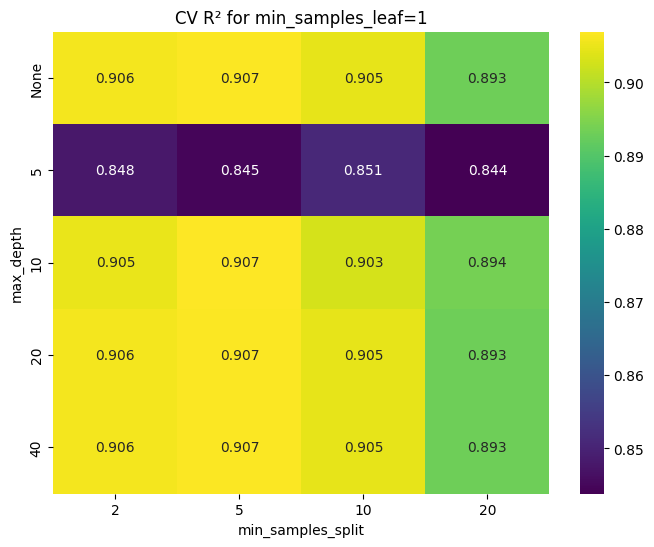

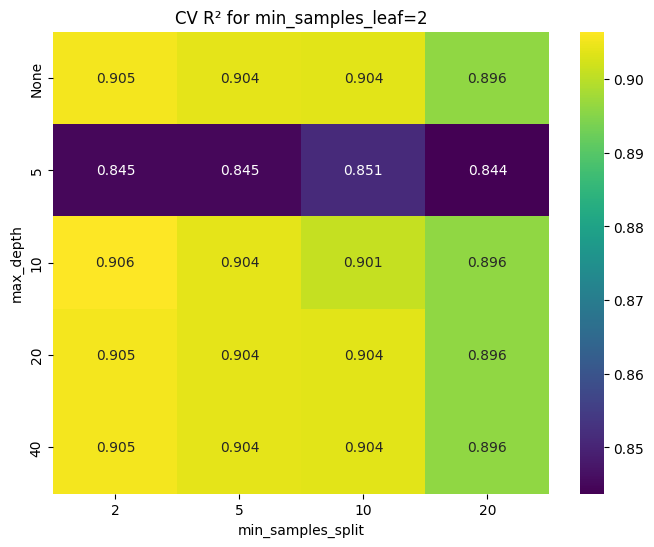

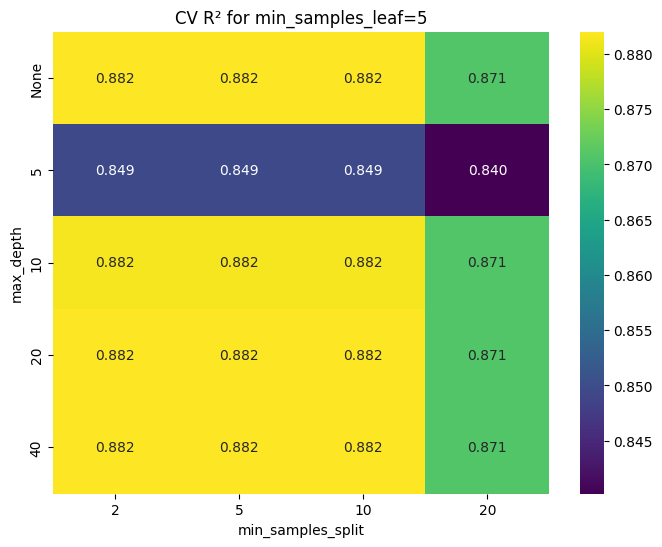

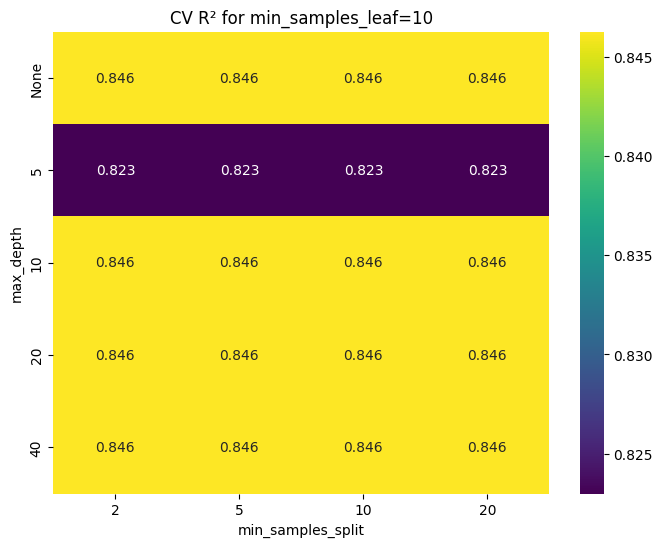

In [10]:

# Heatmaps for each fixed min_samples_leaf
for leaf in min_samples_leaf_list:
    heatmap_data = np.zeros((len(max_depth_list), len(min_samples_split_list)))
    
    for i, depth in enumerate(max_depth_list):
        for j, split in enumerate(min_samples_split_list):
            # Find corresponding mean_r2
            for r in results:
                if r['max_depth'] == depth and r['min_samples_split'] == split and r['min_samples_leaf'] == leaf:
                    heatmap_data[i, j] = r['mean_r2']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".3f",
        xticklabels=min_samples_split_list,
        yticklabels=[str(d) for d in max_depth_list],
        cmap="viridis"
    )
    plt.title(f"CV R² for min_samples_leaf={leaf}")
    plt.xlabel("min_samples_split")
    plt.ylabel("max_depth")
    plt.show()